<a href="https://colab.research.google.com/github/sudarmintosenlau/Text-Classification/blob/main/Submission_Model_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Kali ini tentang klasifikasi text: Kita akan membuat model untuk memprediksi kategori dari text

In [ ]:
# Mengimport Dataset yg dibutuhkan
import pandas as pd
from google.colab import files
filenya = files.upload()

Saving bbc-text.csv to bbc-text.csv


In [ ]:
df = pd.read_csv('bbc-text.csv')                # Meload dataset kedalam dataframe
df.head()                                       # mencetak 5 data ter-atas

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


Mengecek dimensi dataset

In [ ]:
df.info

<bound method DataFrame.info of            category                                               text
0              tech  tv future in the hands of viewers with home th...
1          business  worldcom boss  left books alone  former worldc...
2             sport  tigers wary of farrell  gamble  leicester say ...
3             sport  yeading face newcastle in fa cup premiership s...
4     entertainment  ocean s twelve raids box office ocean s twelve...
...             ...                                                ...
2220       business  cars pull down us retail figures us retail sal...
2221       politics  kilroy unveils immigration policy ex-chatshow ...
2222  entertainment  rem announce new glasgow concert us band rem h...
2223       politics  how political squabbles snowball it s become c...
2224          sport  souness delight at euro progress boss graeme s...

[2225 rows x 2 columns]>

In [ ]:
# import library preprocessing
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Mendefinisikan beberapa parameter sebelum tahap pemprosesan
vocab_size = 5000
embedding_dim = 100
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [ ]:
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


Pre-processing of data

Kita akan mulai membuat tokenizer kemudian membagi dataset ke dalam training dataset dan validation mengunakan rasio *training_portion = 0.8* dan *validation 0.2* sesuai dengan parameter yang sudah ditentukan

In [ ]:
# Menggunakan Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(articles)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(articles)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_size = int(len(articles) * training_portion)
training_sequences = padded[0:train_size]
train_labels = labels[0:train_size]

validation_sequences = padded[train_size:]
validation_labels = labels[train_size:]

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [ ]:
print(training_sequences.shape)
print(validation_sequences.shape)
print(training_label_seq.shape)
print(validation_label_seq.shape)

(1780, 200)
(445, 200)
(1780, 1)
(445, 1)


In [ ]:
print(vocab_size)
print(word_index['i'])

29698
5520


Pertama, kita perlu memuat seluruh file penyisipan kata GloVe ke dalam memori sebagai kamus kata ke array penyematan. Selanjutnya, kita perlu membuat matriks satu embedding untuk setiap kata dalam dataset pelatihan.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-07-09 01:10:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-09 01:10:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-09 01:10:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!ls
!pwd

bbc-text.csv	   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [ ]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs ;
    
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector


Hasilnya adalah matriks bobot hanya untuk kata-kata yang akan kita lihat selama pelatihan.

In [ ]:
print(len(embeddings_matrix))

29699


Sekarang kita dapat mendefinisikan model kita, fit, dan mengevaluasinya seperti sebelumnya. Menyusun Arsitektur menggunakan: Sequential, LSTM, dan Embedding.

Perbedaan utama adalah bahwa lapisan penyematan dapat diunggulkan dengan bobot penyematan kata GloVe.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          2969900   
_________________________________________________________________
dropout (Dropout)            (None, 200, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 3,035,378
Trainable params: 65,478
Non-trainable params: 2,969,900
_________________________________________

In [ ]:
num_epochs = 10
# menggunakan fungsi history supaya hasil latihan bisa diplot
history = model.fit(training_sequences, training_label_seq, epochs=num_epochs, validation_data=(validation_sequences, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 7s - loss: 0.9829 - accuracy: 0.6753 - val_loss: 0.4256 - val_accuracy: 0.8809
Epoch 2/10
56/56 - 4s - loss: 0.2958 - accuracy: 0.9107 - val_loss: 0.2246 - val_accuracy: 0.9258
Epoch 3/10
56/56 - 4s - loss: 0.1895 - accuracy: 0.9438 - val_loss: 0.2226 - val_accuracy: 0.9371
Epoch 4/10
56/56 - 4s - loss: 0.1860 - accuracy: 0.9449 - val_loss: 0.1594 - val_accuracy: 0.9483
Epoch 5/10
56/56 - 4s - loss: 0.1421 - accuracy: 0.9567 - val_loss: 0.2078 - val_accuracy: 0.9258
Epoch 6/10
56/56 - 4s - loss: 0.1707 - accuracy: 0.9478 - val_loss: 0.1634 - val_accuracy: 0.9483
Epoch 7/10
56/56 - 4s - loss: 0.1319 - accuracy: 0.9618 - val_loss: 0.2846 - val_accuracy: 0.8876
Epoch 8/10
56/56 - 4s - loss: 0.1181 - accuracy: 0.9629 - val_loss: 0.0940 - val_accuracy: 0.9708
Epoch 9/10
56/56 - 4s - loss: 0.0968 - accuracy: 0.9719 - val_loss: 0.1297 - val_accuracy: 0.9640
Epoch 10/10
56/56 - 4s - loss: 0.2250 - accuracy: 0.9371 - val_loss: 0.1419 - val_accuracy: 0.9618


Plot loss dan Akurasi pada saat training dan validation

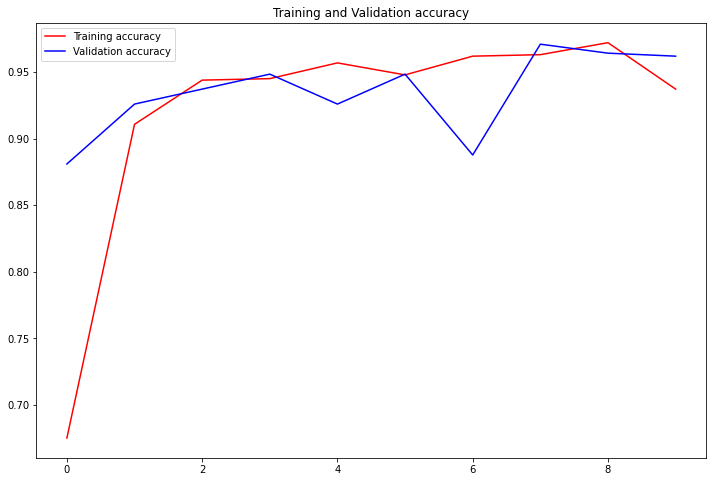

In [ ]:
import matplotlib.pyplot as plt

accur = history.history['accuracy']
val_accur = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accur))

plt.figure(figsize = (12, 8))
plt.plot(epochs, accur, 'r', label = 'Training accuracy')
plt.plot(epochs, val_accur, 'b', label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 0)
plt.show()